# Recurrent Neural Network

In this jupyter notebook we will focus on $\textit{Recurrent Neural Network}$ which is a neural network that makes use of sequential information. It uses the order of inputs to create a logical connection between them, which is very useful in tasks like natural language processing, speech recognition and video activity recognition. 


<img src="rec_neu_net/rec_net.png"  style="width=:70% ;height=:70%">

# Problem
For a given set $D = \{(x_n, y_n)\}_{n=1}^N$ classify each $\textit{y}_t$ for the new $\textbf{x}$. Where $\textit{y}_t$ is a single 'word' of whole output sequence $\textit{y}$.

<h3>Examples</h3>


<img src="rec_neu_net/thanks_to_Andrew.png" style="width=:70% ;height=:70%">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from functools import reduce

# Simple Example:

We are going to create Recurrent Neural Network (RNN) model to add binary numbers up to 256.
<img src="rec_neu_net/binary_summation.gif" style="width:30% ;height:30%;">



# Input Data
First of all we need to prepare some data for training. To do so we will create a dictionary that maps integers for binaries.

In [2]:
def create_int2bin_dict(binary_dim=8):
    '''
    returns a dictionary of integers tranlsated to binaries
    '''
    int2binary = {}

    largest_number = pow(2, binary_dim)
    binary = np.unpackbits(
        np.array([range(largest_number)], dtype=np.uint8).T, axis=1)
    for i in range(largest_number):
        int2binary[i] = binary[i]
    return int2binary

In [3]:
int2binary = create_int2bin_dict()

integers = [5, 109, 21]
for integer in integers:
    print('Integer: {}, binary format: {}'.format(integer, int2binary[integer]))



Integer: 5, binary format: [0 0 0 0 0 1 0 1]
Integer: 109, binary format: [0 1 1 0 1 1 0 1]
Integer: 21, binary format: [0 0 0 1 0 1 0 1]


# RNN Model

We will create RNN with one hidden layer. RNN differs from simple feedforward NN as the output is dependent not only from input, but also from previous computations. We need to provide data from previous iterations on single sequence.

<img src="rec_neu_net/rec_net_explained.png" style="width:60% ;height:60%;">

Notice that on the image Wxa are weights between input and hidden layer, Wah are weights between hidden layer and Waa are weights between hidden layers.

Just like in feedforward neural network we are in need of some non-linear functions like sigmoid.

# Sigmoid
We are going to use sigmoid non-linear function, that is defined:

$\sigma(x) = \frac{1}{1+e^{-x}}$

And looks like this below:
<img src="rec_neu_net/sigmoid.jpg" height="40%" width="40%">

We also need to know sigmoid derivative which is equal to:
$\frac{\delta \sigma}{\delta x} = \sigma(x) \cdot (1 - \sigma(x)) $

In [4]:
def sigmoid(x):
    '''
    param x: input matrix of size NxM
    '''
    return 1/(1+np.exp(-x))


In [5]:
print('Sigmoid for small value f.e. -100 equals: {:.3f}'.format(sigmoid(-100)))
print('Sigmoid of big values f.e. 100 equals: {:.3f}'.format(sigmoid(100)))

Sigmoid for small value f.e. -100 equals: 0.000
Sigmoid of big values f.e. 100 equals: 1.000


# Notation:
$x^{<t>}$ - the $t^{th}$ input of the sequence

$z^{<t>}$ - values in activation layer before non-linear function at $t^{th}$ element of the sequence

$a^{<t>}$ - values in activation layer at $t^{th}$ element of the sequence, that equals $\sigma(z^{<t>})$

$y^{<t>}$ - true output for $x^{<t>}$ input 

$h^{<t>}$ - output layer vaule for $x^{<t>}$ input before non-linear function

$\overline{y}^{<t>}$ - predicted output for $x^{<t>}$ input after activation with non-linear function, that equals $\sigma(h^{<t>})$


$a^{<t-1>}$ - values in activation layer at $(t-1)^{th}$ element of the sequence (*for t=0 element in the sequence we assume $a^{<t-1>}$ equals zero)

$W_{aa}$ - weights between $a^{<t-1>}$ and $a^{<t>}$ in the sequence.

$W_{xa}$ - weights between input layer and hidden layer

$W_{ay}$ - weights between hidden layer and output layer

$\sigma(z)$ - sigmoid non-linear function on variable z

$T $ - whole lenght of a sequence

# Variables initialization

We need to initialize weights and biases for our network, as matrices filled with random values of proper sizes.

In [6]:
def initialize_random_weights(input_dim, hidden_dim, output_dim):
    '''
    param input_dim: number of cells in input layer
    param output_dim: number of cells in output layer 
    param hidden_dim: number of nods in hidden layer
    return: tuple of Wxa, Waa, Way
    '''
    np.random.seed(100)
    Wxa = 2 * np.random.random((input_dim, hidden_dim)) - 1
    Waa = 2*np.random.random((hidden_dim, hidden_dim))-1
    Way = 2 * np.random.random((hidden_dim, output_dim)) - 1


    return (Wxa, Waa, Way)

In [7]:
#example usage
Wxa, Waa, Way = initialize_random_weights(input_dim = 2, hidden_dim = 10, output_dim=1)

print("Wxa (from input layer to hidden layer) shape: {}".format(Wxa.shape))
print("Waa (from previous execution of hidden layer to current hidden layer) shape: {}".format(Waa.shape))
print("Way (from hidden layer to output layer) shape: {}".format(Way.shape))



Wxa (from input layer to hidden layer) shape: (2, 10)
Waa (from previous execution of hidden layer to current hidden layer) shape: (10, 10)
Way (from hidden layer to output layer) shape: (10, 1)


# Feed forward for single element - steps and description

<h3>Steps: </h3>
1. $z^{<t>} = W_{aa} \times a^{<t-1>} + W_{xa} \times x^{<th>}$
2. $a^{<t>} = \sigma(z^{<t>})$
3. $\overline{y}^{<t>} = \sigma(W_{ay} \times a^{<t>})$

We need to compute values at hidden layer for $t^{th}$ element using $x^{<t>}$ input and $a^{<t-1>}$ hidden layer values, and then with them we can compute $\overline{y}^{<t>}$ output. 

<img src="rec_neu_net/feed_forward.gif" height="60%" width="60%">

As we can see on this animation values at hidden layer depends not only on input, but also on values of hidden layers for previous inputs.


In [8]:
def feed_forward(a, b, W):
    '''
    param a: input vector - binary number
    param b: input vector - 2nd binary number 
    param W: tuple of Wxa, Waa, Way
    return: pair of lists y_values, hidden_values 
    '''
    binary_dim = a.shape[0]
    
    Wxa, Waa, Way = W
    
    hidden_dim = Waa.shape[0]
    
    hidden_values = []
    hidden_values.append(np.zeros((1, hidden_dim)))
    
    y_values = [] 
    
    for t in range(binary_dim):
        x_t = np.array([[a[binary_dim - t - 1], b[binary_dim - t - 1]]]) 

        z_t = x_t @ Wxa + hidden_values[-1] @ Waa
        a_t = sigmoid(z_t)

        h_t = a_t @ Way
        y_t = sigmoid(h_t)

        y_values.append(y_t)
        hidden_values.append(a_t)
        
    
    return y_values, hidden_values

# Cost function:

At start weights are random numbers, so we need to find parameters that will predict output with the smallest error. we are going to search for them using gradient descent, which is a method that allows to reach local minimum by substracting derivatives values from weights.

Before computing the gradient we need to define cost function, which in our case will be cross-entropy, but we could use mean squared error as well for this task:  $J = \frac{1}{N}\sum_{i=0}^N \big( y_i \cdot \ln{\overline{y}_i + (1-y_i)\cdot(\ln{(1-\overline{y}_i)}) } \big)$

The cost function will let us measure how bad our model works.

# Backpropagation

After defining cost function we can go to the part that is responsible for learning parameters - called backpropagation, with use of gradient descent.

<h3>Gradient descent steps in sequence</h3>

1. Compute the error on $\overline{y}$ as derivative of the cost function (gradient)
2. Compute the error on output layer before activation
3. Compute the gradient of weights $W_{ay}$
4. Compute the error on $a$ using chain rule from output and error from next execution of hidden layer. For last layer we assume that error on 'next' execution equals 0 as it doesn't exist.
5. Compute the error on $z$ from $a$
6. Compute the gradient of weights $W_{aa}$
7. Compute the gradient of weights $W_{xa}$ 

<h3>Gradient descent in steps for people familiar with calculus</h3>

1) Error on $\overline{y}^{<t>} = \frac{\delta J}{\delta \overline{y}^{<t>}} = \frac{\delta y^{<t>}}{\delta\overline{y}^{<t>}} - \frac{1-y^{<t>}}{(1-\overline{y}^{<t>})} = 
\frac{y^{<t>}-\overline{y}^{<t>}}{\overline{y}^{<t>}\cdot(\overline{y}^{<t>}-1)}$


2) Error on $h^{<t>} = \frac{\delta J}{\delta h^{<t>}} =  \frac{\delta J}{\delta \overline{y}^{<t>}} \cdot \frac{\delta \overline{y}^{<t>}}{\delta h^{<t>}} = \frac{y^{<t>} - \overline{y}^{<t>}}{\overline{y}^{<t>}\cdot(\overline{y}^{<t>}-1)} \cdot (\overline{y}^{<t>}\cdot(\overline{y}^{<t>}-1)) = y^{<t>} - \overline{y}^{<t>} $


3) Gradient of $W_{ay} = \frac{\delta J}{\delta W_{ay}} = \sum_{t=0}^{T} \big( \frac{\delta J}{\delta \overline{y}^{<t>}} \cdot \frac{\delta \overline{y}^{<t>}}{\delta h^{<t>}} \cdot \frac{\delta h^{<t>}}{\delta W_{ay}} \big) =
\sum_{t=0}^{T} \big( \frac{\delta {J}}{\delta h^{<t>}} \cdot \frac{\delta h^{<t>}}{\delta W_{ay}} \big) =
\sum_{t=0}^{T} \big( \frac{\delta {J}}{\delta h^{<t>}} \cdot a^{<t>} \big)$, as $\frac{\delta h^{<t>}}{\delta W_{ay}} = a^{<t>}$, because $h^{<t>} = a^{<t>} \times W_{ay} $ 


4) Error on $a^{<t>} = \frac{\delta J}{\delta a^{<t>}} = \sum_{i=t}^T \big( \frac{\delta J}{\delta h^{<i>}} \cdot \frac{\delta h^{<i>}}{\delta a^{<t>}} \big) = \frac{\delta J}{\delta h^{<t>}} \cdot \frac{\delta h^{<t>}}{\delta a^{<t>}} + \frac{\delta J}{\delta a^{<t+1>}} \cdot \frac{\delta a^{<t+1>}}{\delta a^{<t>}} 
= \frac{\delta J}{\delta h^{<t>}} \cdot W_{ay} + \frac{\delta J}{\delta a^{<t+1>}} \cdot W_{aa}
$, as $\frac{\delta h^{<t>}}{\delta a^{<t>}} = W_{ay}$ and $\frac{\delta a^{<t+1>}}{\delta a^{<t>}}= W_{aa} $, because
$h^{<t>} = a^{<t>} \times W_{ay}$ and $ a^{<t+1>} = a^{<t>} \times W_{aa}$

<i>At this point you can get a little shock, but it only looks terrible. Calculating the first part of $\frac{\delta J}{\delta a^{<t>}}$ that comes from $h^{<t>}$ layer works just like in feedforward neural network. Rest of the sum comes from passing the data from hidden layer$^{<t>}$ to hidden layer in execution$^{<t+1>}$. Anyway - all you need to do is to calculate the error on last execution of hidden layer, that equals 0 + the part from $h^{<T>}$ layer. And then use this error to calculate error on execution$^{<T-1>}$ and go again and again backward until you get error on first execution  of hidden layer ($a^{<0>}$)</i>


5) Error on $z^{<t>} = \frac{\delta J}{\delta z^{<t>}} = \frac{\delta J}{\delta a^{<t>}} \cdot \frac{\delta a^{<t>}}{\delta z^{<t>}} = \frac{\delta J}{\delta a^{<t>}} \cdot a^{<t>}(1-a^{<t>})$, as $\frac{\delta a^{<t>}}{\delta z^{<t>}} = a^{<t>}\cdot(1-a^{<t>}) $, because $a^{<t>} = \sigma(z^{<t>})$


6) Gradient of $W_{aa} = \frac{\delta J}{\delta W_{aa}} = \sum_{t=0}^T \big(\frac{\delta J}{\delta z^{<t>}} \cdot \frac{\delta z^{<t>}}{\delta W_{aa}} \big)  = \sum_{t=0}^T \big(\frac{\delta J}{\delta z^{<t>}}\cdot a^{<t-1>} \big)$, as $\frac{\delta z^{<t>}}{\delta W_{aa}} = a^{<t-1>}$, because $z^{<t>} = x^{<t>} \times W_{xa} + a^{<t-1>} \times W_{aa} $


7) Gradient of $W_{xa} = \frac{\delta J}{\delta W_{xa}} = \sum_{t=0}^T \big(\frac{\delta J}{\delta z^{<t>}} \cdot \frac{\delta z^{<t>}}{\delta W_{xa}}\big) = \sum_{t=0}^T\big(\frac{\delta J}{\delta z^{<t>}}\cdot x^{<t>}\big)$, as $\frac{\delta z^{<t>}}{\delta W_{xa}} = x^{<t>}$, because $z^{<t>} = x^{<t>} \times W_{xa} + a^{<t-1>} \times W_{aa} $

In the code you can see the same operations done on matrices. Somewhere there code will be a little bit diffrent due to matrices operations (to compute gradient sometimes it's needed to transpose matrix).

<img src="rec_neu_net/backprop_through_time.gif" height="60%" width="60%">

In [9]:
def back_propagation(a, b, c, W, y_values, hidden_values):
    '''
    param a: ndarray- binary number, one of the inputs
    param b: ndarray - binary number, second of the inputs
    param c: ndarray - the true output
    param W: tuple of weights Wax, Waa, Way
    param y_values: ndarray of predicted output
    param hidden_values: ndarray, activation layer values at each execution t
    '''
    binary_dim = a.shape[0]

    error = 0

    Wxa, Waa, Way = W

    hidden_dimension = Waa.shape[0]

    Wxa_update = 0
    Waa_update = 0
    Way_update = 0
    
    next_input_hidden_delta = np.zeros((1, hidden_dimension))

    for t in range(binary_dim):
        predicted = y_values[-t - 1]

        y = np.array([[c[t]]])

        error += np.abs(np.mean(y * np.log(predicted) + (1 - y) * np.log(1 - predicted)))
        dJ_dz3 = -(y - predicted)

        x = np.array([[a[t], b[t]]])
        a2 = hidden_values[-t - 1]
        prev_a2 = hidden_values[-t - 2]

        dJ_da2 = next_input_hidden_delta @ Waa.T + dJ_dz3 @ Way.T
        dJ_dz2 = dJ_da2 * (a2 * (1-a2))

        Way_update += a2.T @ dJ_dz3
        Waa_update += prev_a2.T @ dJ_dz2
        Wxa_update += x.T @ dJ_dz2

        next_input_hidden_delta = dJ_dz2

    W_updates = (Wxa_update, Waa_update, Way_update)

    return W_updates, error

# Training
After backpropagation we can update weights by substracting from them those gradients multiplied by hyperparamter called learning rate, which defines how fast our model is learning itself.

<h3> Steps for training </h3>
$W_{ax} := W_{ax} - learning\_rate \cdot \frac{\delta J}{\delta W_{ax}}$

$W_{aa} := W_{aa} - learning\_rate \cdot \frac{\delta J}{\delta W_{aa}}$

$W_{ay} := W_{ay} - learning\_rate \cdot \frac{\delta J}{\delta W_{ay}}$


0 - Initialize weights with random values

For k times (where k is number of epochs)

1. Process forward pass to get values at layers
2. Process backward pass to get error at weights
3. Update weights to be closer to Cost function minimum

In [10]:
def train(int2binary, binary_dimension, input_dimension=2, 
          hidden_dimension=16, output_dimension=1, epochs=10_000, learning_rate=1e-3):
    '''
    param int2binary: dictionary that mpas integer numbers into binary

    param binary_dimension: max length of binary number

    param input_dimension: number of nodes in input layer for single execution

    param hidden_dimension: nubmer of nodes in hidden layer

    param output_dimension: number of nodes in output layer for single execution

    param epochs: number of epochs
    
    param learning rate: hyperparameter - rate of learning speed
    
    return: funcion return weights Wxa, Waa, Way and costs
    '''

    largest_number = pow(2, binary_dimension)


    Wxa = 2 * np.random.random((input_dimension, hidden_dimension)) - 1
    Waa = 2 * np.random.random((hidden_dimension, hidden_dimension)) - 1
    Way = 2 * np.random.random((hidden_dimension, output_dimension)) - 1

    costs_in_batch = []
    costs = []

    for epoch in tqdm_notebook(range(epochs)):
        # first binary number
        a_int = np.random.randint(largest_number / 2)  # int version
        a = int2binary[a_int]

        # second binary number
        b_int = np.random.randint(largest_number / 2)  # int version
        b = int2binary[b_int]

        # true answer
        c_int = a_int + b_int
        c = int2binary[c_int]

        W = (Wxa, Waa, Way)

        y_values, hidden_values = feed_forward(a, b, W)

        W_updates, cost = back_propagation(a, b, c, W, y_values, hidden_values)

        costs_in_batch.append(cost)

        if epoch % 500 == 1:
            mean_in_batch = reduce(lambda x, y: x + y, costs_in_batch) / len(costs_in_batch)
            costs.append(mean_in_batch)
            costs_in_batch = []

        Wxa_update, Waa_update, Way_update = W_updates

        Wxa -= Wxa_update * learning_rate
        Waa -= Waa_update * learning_rate
        Way -= Way_update * learning_rate



    W = Wxa, Waa, Way

    return W, costs

# Prediction

Prediction is a single feed forward part for each input pair, to generate expected sum.

In [11]:
def predict(int2binary, binary_dim, W):
    '''
    param int2binary: dictionary that maps integer values into binary
    param binary_dim: maximum length of binary number
    param W: tuple of weights Wxa, Waa, Way
    
    '''
    Wxa, Waa, Way = W


    largest_number = pow(2, binary_dim)

    # first binary number
    a_int = np.random.randint(largest_number / 2)  # int version
    a = int2binary[a_int]

    # second binary number
    b_int = np.random.randint(largest_number / 2)  # int version
    b = int2binary[b_int]

    # true answer
    c_int = a_int + b_int
    c = int2binary[c_int]

    hidden_dimension = Waa.shape[0]

    prediction = np.zeros_like(c)

    hidden_values = [np.zeros((1, hidden_dimension))]

    for t in range(binary_dim):
        x_t = np.array([[a[binary_dim - t - 1], b[binary_dim - t - 1]]])

        z_t = x_t @ Wxa + hidden_values[-1] @ Waa
        a_t = sigmoid(z_t)

        h_t = a_t @ Way
        y_t = sigmoid(h_t)

        prediction[binary_dim - t - 1] = np.round(y_t)

        hidden_values.append(a_t)

    print("Predicted:" + str(prediction))
    print("True:" + str(c))

    out = 0
    for index, x in enumerate(reversed(prediction)):
        out += x * pow(2, index)
    print(str(a_int) + " + " + str(b_int) + " = " + str(out))

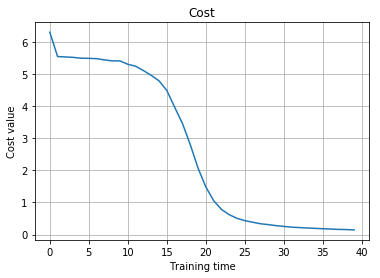

Predicted:[1 0 0 1 1 0 1 1]
True:[1 0 0 1 1 0 1 1]
39 + 116 = 155
Predicted:[1 1 0 1 0 0 0 1]
True:[1 1 0 1 0 0 0 1]
83 + 126 = 209
Predicted:[0 1 0 1 1 0 0 1]
True:[0 1 0 1 1 0 0 1]
68 + 21 = 89
Predicted:[0 1 0 0 1 1 0 1]
True:[0 1 0 0 1 1 0 1]
28 + 49 = 77
Predicted:[0 1 1 1 1 1 1 0]
True:[0 1 1 1 1 1 1 0]
24 + 102 = 126
Predicted:[1 0 0 0 0 0 0 0]
True:[1 0 0 0 0 0 0 0]
11 + 117 = 128
Predicted:[1 0 1 1 0 1 0 0]
True:[1 0 1 1 0 1 0 0]
83 + 97 = 180
Predicted:[1 0 0 1 0 0 1 1]
True:[1 0 0 1 0 0 1 1]
44 + 103 = 147
Predicted:[0 1 0 1 1 1 0 1]
True:[0 1 0 1 1 1 0 1]
79 + 14 = 93
Predicted:[0 0 1 1 1 0 1 1]
True:[0 0 1 1 1 0 1 1]
19 + 40 = 59


In [12]:
np.random.seed(0)

binary_dim = 8
largest_number = pow(2, binary_dim)
int2binary = create_int2bin_dict(binary_dim)

W, costs = train(int2binary, binary_dim, epochs=20_000, learning_rate=1e-2)

plt.plot(costs)
plt.xlabel('Training time')
plt.ylabel('Cost value')
plt.title('Cost')
plt.grid()
plt.show()

for i in range(10):
    predict(int2binary, binary_dim, W)

# Sources:

Followed sources were usefull during creating this notebook:

https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/, Andrew Trask the whole idea about summing up binaries, gifs about feed forward and backpropagation.

https://magenta.tensorflow.org/2016/06/10/recurrent-neural-network-generation-tutorial, scheme image of recurrent neural network

https://www.coursera.org/specializations/deep-learning, Prof. Andrew Ng - examples of RNN usage 




